# Neural Machine Translation at word-level without Attention Mechanism

## Download and Prepare Dataset

Dataset downloaded from :  Dataset downloaded from: http://www.manythings.org/anki/deu-eng.zip

In [4]:
import tensorflow as tf
import re
import string
import numpy as np
from unicodedata import normalize
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [5]:
path_to_file = "dataset/deu.txt"
MAX_LINES = 20000

In [6]:
def load_data(filename):
    """ Return data set as a list of pair-list"""
    file = open(filename, mode='rt', encoding='utf-8')
    text = file.read()
    lines = text.split('\n')
    pairs = [line.split('\t')[:2] for line in lines[:min(MAX_LINES, len(lines) - 1)]]
    return pairs

def clean_pairs(pairs):
    cleaned = list()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    for pair in pairs:
        clean_pair = []
        for line in pair:
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            line = line.split()
            line = [word.lower() for word in line]
            line = [re_punc.sub('', w) for w in line]
            line = [re_print.sub('', w) for w in line]
            line = [word for word in line if word.isalpha()]
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return cleaned

def encode_one_hot(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [7]:
pairs = load_data(path_to_file)
cleaned_pairs = clean_pairs(pairs)
en = [en for [en, ger] in cleaned_pairs]
ger = [ger for [en, ger] in cleaned_pairs]
ger = list(map(lambda x : '<sos> ' +  x  + ' <eos>' , ger))

In [8]:
# to change input/target language
input_lang = en
targ_lang = ger

In [9]:
def tokenizer(text):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(text)
    sequence = tokenizer.texts_to_sequences(text)
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post')
    return padded_sequence, tokenizer

In [10]:
# padded sequence and tokenier of input/target language
input_seq, input_tokenizer = tokenizer(input_lang)
target_seq, target_tokenizer = tokenizer(targ_lang)

# maximum length of input and target language
max_input_length = input_seq.shape[1]
max_target_length = target_seq.shape[1]

# vocab size of input/target language
input_vocab_size = len(input_tokenizer.word_index)+1
target_vocab_size = len(target_tokenizer.word_index)+1

In [11]:
# Input/output of encoder decoder

encoder_input_data = encode_one_hot(input_seq, input_vocab_size)
target_seq_one_hot = encode_one_hot(target_seq, target_vocab_size)
decoder_input_data = target_seq_one_hot[:,:-1,:]
decoder_output_data = target_seq_one_hot[:, 1:,:]

### Build the Model

In [15]:
LATENT_DIM = 128

# Define Encoder/Decoder

# Encoder
encoder_input = Input(shape=(None, input_vocab_size), 
                      name='encoder_input')
encoder_lstm = LSTM(LATENT_DIM, 
                    return_sequences=True, 
                    return_state=True, 
                    name='encoder_lstm')
encoder_outputs, enc_state_h, enc_state_c = encoder_lstm(encoder_input)
encoder_state = [enc_state_h, enc_state_c]


# Decoder
decoder_input = Input(shape=[None, target_vocab_size],
                     name='decoder_input')
decoder_lstm = LSTM(LATENT_DIM,
                   return_sequences=True,
                   return_state=True,
                   name='decoder_lstm')
dec_h_output, dec_state_h, dec_state_c = decoder_lstm(decoder_input,
                                                     initial_state=encoder_state,)
#Apply attention mechanism
attention_layer = AdditiveAttention(128,name='attention_layer')
context_vector = attention_layer([dec_h_output, encoder_outputs])
concat_layer = Concatenate(axis=-1, name='concat_layer')
attention_concat_input = concat_layer([context_vector, dec_h_output])
# attention_dense = Dense(LATENT_DIM,
#                        activation='tanh',
#                        name='attention_dense')                        
# decoder_dense_input = attention_dense(attention_dense_input)
                        
decoder_dense = Dense(target_vocab_size, 
                      activation='softmax', 
                      name='decoder_dense')
dense_time = TimeDistributed(decoder_dense, name='time_distributed_layer')

decoder_output = dense_time(attention_concat_input)


# Model
model = Model([encoder_input, decoder_input],
              decoder_output,
             name='encoder_decoder_model')

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "encoder_decoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None, 3655)] 0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 5657)] 0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, None, 128),  1937408     encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 128),  2962432     decoder_input[0][0]              
                                                                 encoder_lstm[

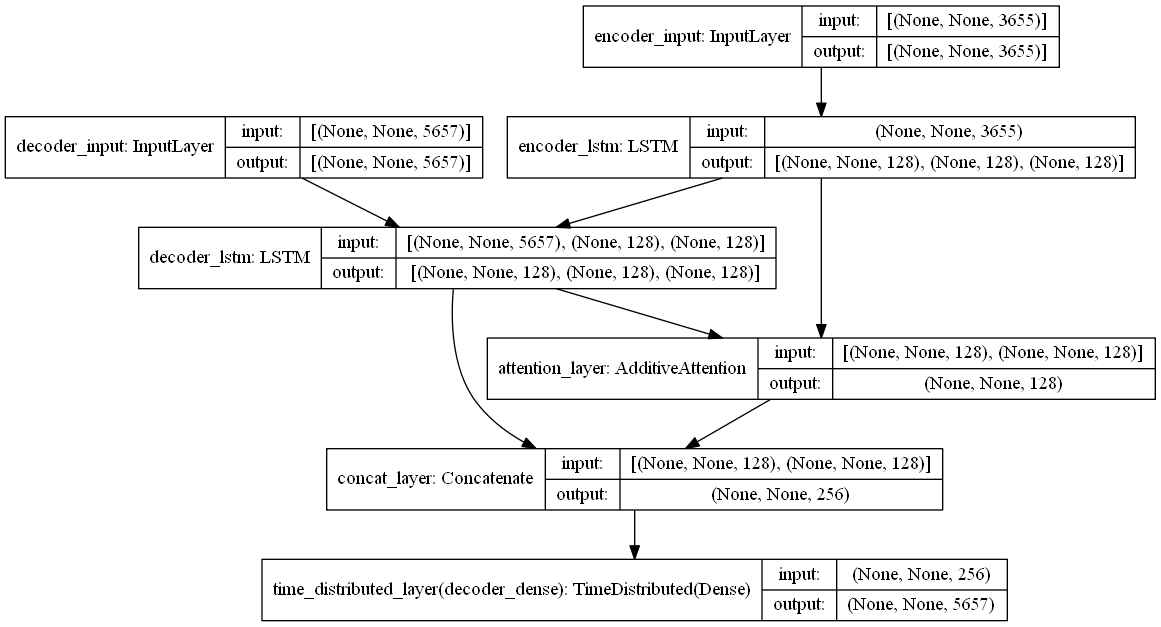

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [18]:
# Early stopping callback
es_callback = tf.keras.callbacks.EarlyStopping(patience=10,
                                              restore_best_weights=True)

In [20]:
# Fit the Model
history = model.fit([encoder_input_data, decoder_input_data], 
                                    decoder_output_data,
                                    epochs=30,
                                    validation_split=0.2,
                                    callbacks = [es_callback])
model.save('model_encoder_decoder_translation_with_attention.h5')

Epoch 1/30
500/500 [==============================] - 194s 387ms/step - loss: 1.9760 - accuracy: 0.6929 - val_loss: 2.1075 - val_accuracy: 0.7085
Epoch 2/30
500/500 [==============================] - 181s 363ms/step - loss: 1.6547 - accuracy: 0.7487 - val_loss: 1.9118 - val_accuracy: 0.7272
Epoch 3/30
500/500 [==============================] - 180s 359ms/step - loss: 1.4508 - accuracy: 0.7736 - val_loss: 1.7917 - val_accuracy: 0.7499
Epoch 4/30
500/500 [==============================] - 146s 291ms/step - loss: 1.2871 - accuracy: 0.7919 - val_loss: 1.7018 - val_accuracy: 0.7638
Epoch 5/30
500/500 [==============================] - 145s 291ms/step - loss: 1.1294 - accuracy: 0.8097 - val_loss: 1.6120 - val_accuracy: 0.7759
Epoch 6/30
500/500 [==============================] - 146s 292ms/step - loss: 0.9717 - accuracy: 0.8261 - val_loss: 1.5276 - val_accuracy: 0.7894
Epoch 7/30
500/500 [==============================] - 151s 301ms/step - loss: 0.8218 - accuracy: 0.8429 - val_loss: 1.4779 -

In [12]:
model = keras.models.load_model('model_encoder_decoder_translation_with_attention.h5')

In [66]:
LATENT_DIM = 128

encoder_inputs = model.input[0]  # input_1
encoder_outputs, enc_state_h, enc_state_c = model.layers[2].output  # lstm_1
encoder_model = keras.Model(encoder_inputs, [encoder_outputs, enc_state_h, enc_state_c])

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(LATENT_DIM,))
decoder_state_input_c = keras.Input(shape=(LATENT_DIM,))
decoder_input_attention = keras.Input(shape=(None, LATENT_DIM))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
dec_output, state_h_dec, state_c_dec = decoder_lstm(decoder_inputs, 
                                                    initial_state=decoder_states_inputs
                                                   )
decoder_states = [state_h_dec, state_c_dec]

attention = model.layers[4]
context_vector = attention([dec_output, decoder_input_attention])
concat_layer = model.layers[5]
concat_output = concat_layer([context_vector, dec_output])
time_distributed = model.layers[6]
decoder_output = time_distributed(concat_output)

decoder_model = keras.Model(
    [decoder_inputs] + [decoder_input_attention] + decoder_states_inputs, 
    [decoder_output] + decoder_states
)

target_word_index = target_tokenizer.word_index
reverse_target_word_index = dict((i, char) for char, i in target_tokenizer.word_index.items())

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    enc_out, states_h, state_c = encoder_model.predict(input_seq)
    states_value = [states_h, state_c]
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, target_vocab_size))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_word_index["<sos>"]] = 1.0
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_out] + [states_value])
        # Sample a token
        sampled_word_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index[sampled_word_index]
        decoded_sentence.append(sampled_word)

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_word == "<eos>" or len(decoded_sentence) > max_target_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, target_vocab_size))
        target_seq[0, 0, sampled_word_index] = 1.0
        # Update states
        states_value = [h, c]
    return ' '.join(decoded_sentence[:-1])

In [68]:
for seq_index in range(15000,15020):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-") 
    print("Input sentence:", input_lang[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: youre unbiased
Decoded sentence: du bist unvoreingenommen
-
Input sentence: youre unbiased
Decoded sentence: du bist unvoreingenommen
-
Input sentence: youre up early
Decoded sentence: du bist aber fruh auf
-
Input sentence: youre wasteful
Decoded sentence: ihr seid verschwenderisch
-
Input sentence: youre wasteful
Decoded sentence: ihr seid verschwenderisch
-
Input sentence: youre wasteful
Decoded sentence: ihr seid verschwenderisch
-
Input sentence: youre wasteful
Decoded sentence: ihr seid verschwenderisch
-
Input sentence: youre wasteful
Decoded sentence: ihr seid verschwenderisch
-
Input sentence: youre wasteful
Decoded sentence: ihr seid verschwenderisch
-
Input sentence: youve been had
Decoded sentence: ihr seid reingelegt worden
-
Input sentence: youve found it
Decoded sentence: du hast es gefunden
-
Input sentence: youve found it
Decoded sentence: du hast es gefunden
-
Input sentence: youve found it
Decoded sentence: du hast es gefunden
-
Input sentence: youv

In [26]:
model.layers[6]